2) A. Lakukan loading dan scaling data serta tampilkan contoh data yang 
digunakan. Kemudian pisahkan dataset menjadi 80% training set, 10% validation set dan 10% 
test set. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
from sklearn.preprocessing import MinMaxScaler

#Load data

def read_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype=np.dtype('>i4'))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num = np.frombuffer(f.read(8), dtype=np.dtype('>i4'))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

train_images = read_images('D://train-images-idx3-ubyte.gz')
train_labels = read_labels('D://train-labels-idx1-ubyte.gz')
test_images = read_images('D://t10k-images-idx3-ubyte.gz')
test_labels = read_labels('D://t10k-labels-idx1-ubyte.gz')

In [2]:
#Filter untuk class 2 dan 3
train_filter = np.where((train_labels == 2) | (train_labels == 3))
test_filter = np.where((test_labels == 2) | (test_labels == 3))

train_images, train_labels = train_images[train_filter], train_labels[train_filter]
test_images, test_labels = test_images[test_filter], test_labels[test_filter]

train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

In [3]:
#Combine train dan test set

all_images = np.concatenate((train_images, test_images))
all_labels = np.concatenate((train_labels, test_labels))

all_images_reshaped = all_images.reshape((all_images.shape[0], -1))

#Scaling data

scaler = MinMaxScaler()

scaled_images = scaler.fit_transform(all_images_reshaped)
scaled_images = scaled_images.reshape(all_images.shape)


In [4]:
#Splitting data(80% training set, 10% validation set dan 10% test set)

train_images, temp_images, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)

train_images_reshaped = np.reshape(train_images, (train_images.shape[0], 28, 28, 1))
val_images_reshaped = np.reshape(val_images, (val_images.shape[0], 28, 28, 1))
test_images_reshaped = np.reshape(test_images, (test_images.shape[0], 28, 28, 1))

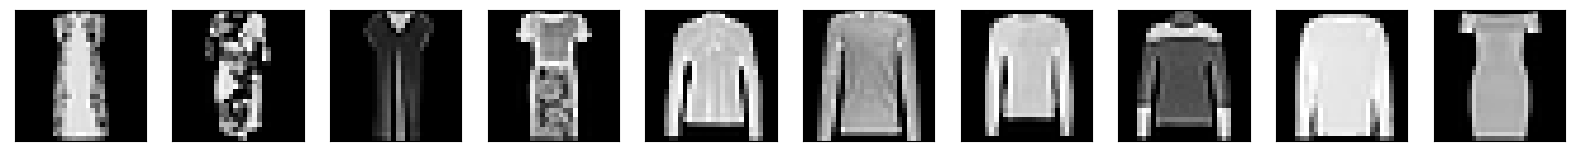

In [5]:
#Example images

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

2)B. Buatlah arsitektur baseline untuk Dimension Reduction dari dimensi 784 
(28x28) menjadi dimensi 128, sesuai dengan gambar arsitektur Autoencoder berikut ini. 
Lakukan evaluasi kualitas citra hasil decoder menggunakan Structural Similarity Index (SSIM) 
pada data test.

In [6]:
from tensorflow.keras import layers, models

#Encoder
encoder_input = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)  
x = layers.MaxPooling2D((2, 2), padding='same')(x)  
x = layers.Flatten()(x)  
encoder_output = layers.Dense(128, activation='relu')(x)  

encoder = models.Model(encoder_input, encoder_output, name="encoder")

In [7]:
#Decoder
decoder_input = layers.Input(shape=(128,))
x = layers.Dense(6272, activation='relu')(decoder_input)  
x = layers.Reshape((14, 14, 32))(x)  
x = layers.UpSampling2D((2, 2))(x)  
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)  
decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  

decoder = models.Model(decoder_input, decoder_output, name="decoder")


In [8]:
autoencoder_input = encoder_input
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)

autoencoder = models.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 128)                 │         803,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         818,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,621,889 (6.19 MB)

 Trainable params: 1,621,889 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

history = autoencoder.fit(
    train_images_reshaped, train_images_reshaped,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(val_images_reshaped, val_images_reshaped)
)

decoded_imgs = autoencoder.predict(test_images_reshaped)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.5687 - val_loss: 0.3621
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 0.3513 - val_loss: 0.3266
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 0.3271 - val_loss: 0.3150
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 0.3175 - val_loss: 0.3066
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.3079 - val_loss: 0.3021
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.3056 - val_loss: 0.2978
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.3012 - val_loss: 0.2953
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.2996 - val_loss: 0.2932
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - loss: 0.2968 - val_loss: 0.2911
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 0.2945 - val_loss: 0.2896
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [10]:
#SSIM

ssim_scores = []
for i in range(100):
    ssim_score = ssim(test_images_reshaped[i].squeeze(), decoded_imgs[i].squeeze(), data_range=decoded_imgs[i].squeeze().max() - decoded_imgs[i].squeeze().min())
    ssim_scores.append(ssim_score)
    
mean_ssim = np.mean(ssim_scores)
print("Mean SSIM:", mean_ssim)

Mean SSIM: 0.7353132658815866


Nilai Mean SSIM sebesar 0.74 menunjukkan bahwa rata-rata image yang dihasilkan oleh model tersebut cukup mirip dengan real image. SSIM yang mendekati 1 menandakan sudah cukup baik walaupun membutuhkan sedikit perbaikan. Hal ini berarti arsitektur model sudah cukup baik tetapi belum maksimal dan masih membutuhkan beberapa perbaikan, mungkin hyperparameter tuning ataupun penambahan layer. 

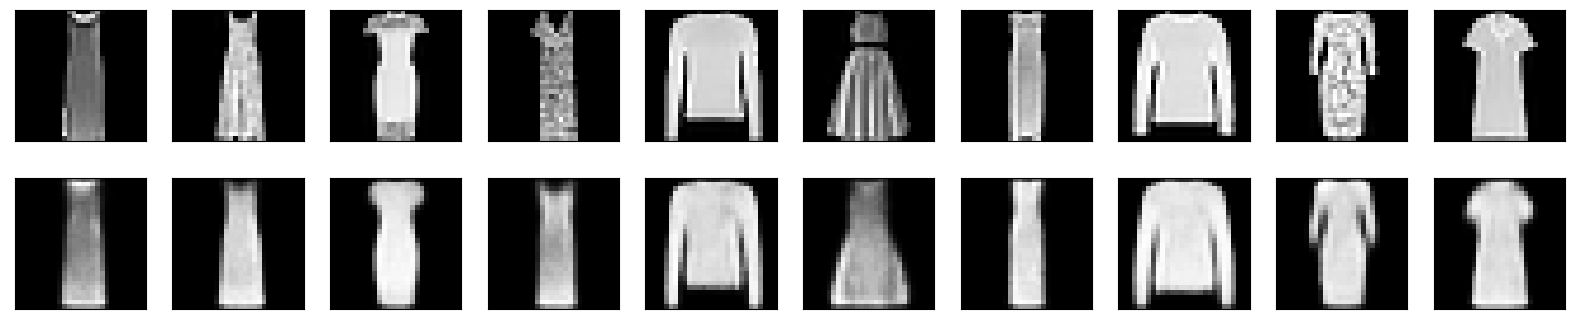

In [11]:
#Visualisasi hasil

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    #Original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images_reshaped[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #Reconstructed Image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

2) C.Setelah mengetahui hasil dari nomor (2b), modifikasi arsitektur 
Autoencoder di atas agar mendapatkan representasi Dimension Reduction yang optimal 
dengan membandingkan hasil Structural Similarity Index (SSIM) nya. Dan selanjutnya lakukan 
proses tuning hyperparameter agar unjuk kerjanya meningkat. Berikan alasan mengapa 
modifikasi arsitektur dan metode tuning hyperparameter kalian lebih baik. 

ANSWER

Dapat disimpulkan bahwa modified model yang dibuat lebih baik dari baseline model. Hal ini dapat dilihat dari loss dan val loss yang sedikit lebih kecil serta nilai SSIM yang lebih besar. Modifikasi yang dilakukan adalah menambahkan layer, dropout, learning rate sebesar 0.0020 dan juga dimension reduction. Saya sudah mencoba menggunakan bentuk arsitektur yang lain, seperti penambahan dan pengurangan layer serta mencoba learning rate yang beragam, akan tetapi model inilah yang memberikan hasil paling baik di antara lainnya. 

In [12]:
#Modified encoder

encoder_input = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)  
x = layers.MaxPooling2D((2, 2), padding='same')(x)  
x = layers.Dropout(0.33)(x)  r
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)  
x = layers.MaxPooling2D((2, 2), padding='same')(x)  
x = layers.Dropout(0.33)(x) 
x = layers.Flatten()(x) 
#dimension reduction
encoder_output = layers.Dense(64, activation='relu')(x)  

encoder = models.Model(encoder_input, encoder_output, name="encoder")


In [13]:
#Modified decoder

decoder_input = layers.Input(shape=(64,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_input)  
x = layers.Reshape((7, 7, 64))(x)  
x = layers.UpSampling2D((2, 2))(x) 
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)  
x = layers.UpSampling2D((2, 2))(x)  
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)  
decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  

decoder = models.Model(decoder_input, decoder_output, name="decoder")


In [14]:
#Autoencoder

autoencoder_input = encoder_input
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)

autoencoder = models.Model(autoencoder_input, decoded_img, name="autoencoder")

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 64)                  │         219,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         259,521 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 479,105 (1.83 MB)

 Trainable params: 479,105 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0020), loss='binary_crossentropy')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    train_images_reshaped, train_images_reshaped,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(val_images_reshaped, val_images_reshaped),
    callbacks=[early_stopping]
)

decoded_imgs = autoencoder.predict(test_images_reshaped)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - loss: 0.4433 - val_loss: 0.3265
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - loss: 0.3237 - val_loss: 0.3215
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step - loss: 0.3112 - val_loss: 0.3142
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step - loss: 0.3029 - val_loss: 0.3077
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - loss: 0.2993 - val_loss: 0.3030
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - loss: 0.2965 - val_loss: 0.3017
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - loss: 0.2945 - val_loss: 0.2941
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - loss: 0.2930 - val_loss: 0.2914
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - loss: 0.2925 - val_loss: 0.2915
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step - loss: 0.2912 - val_loss: 0.2906
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


In [16]:
#SSIM 

ssim_scores = []
for i in range(100):
    ssim_score = ssim(test_images_reshaped[i].squeeze(), decoded_imgs[i].squeeze(), data_range=decoded_imgs[i].squeeze().max() - decoded_imgs[i].squeeze().min())
    ssim_scores.append(ssim_score)

# Calculate the mean SSIM score
mean_ssim = np.mean(ssim_scores)
print("Mean SSIM:", mean_ssim)

Mean SSIM: 0.7470393001669227


Mean SSIM untuk modified model sedikit lebih tinggi dibandingkan baseline model. Walaupun perbedaanya tidak signifikan, tetapi dapat dilihat dari visualisasi hasil bahwa image yang dihasilkan tidak se blurry baseline model. Artinya, image yang dihasilkan oleh model tersebut lebih mendekati real image karena lebih mendekati 1. 

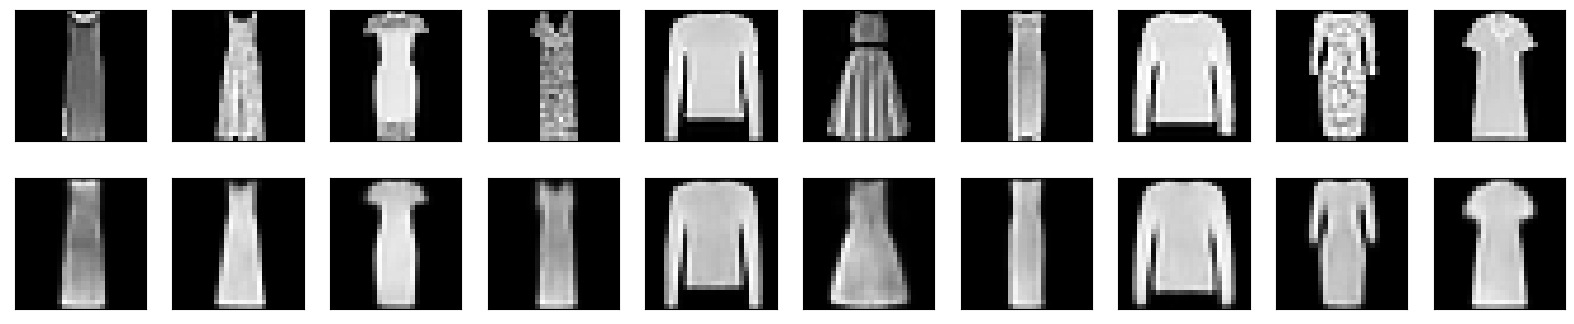

In [17]:
#Visualisasi hasil

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images_reshaped[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()